In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import joblib
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor 


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

c:\Users\user\miniconda3\envs\hospitality_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
data_path = r"C:\Users\user\Desktop\Github\Hotel booking prediction\hotel-booking-prediction\data\cleaned_regression_data.csv"
data = pd.read_csv(data_path)

In [10]:
data.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342.0,2015.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,737.0,2015.0,27.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7.0,2015.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,13.0,2015.0,27.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,14.0,2015.0,27.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


#### One hot-encoding

In [3]:
dummies_columns = data.select_dtypes('object').columns

In [4]:
dummies_columns

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'deposit_type', 'customer_type'],
      dtype='object')

In [5]:
data = pd.get_dummies(data, columns=dummies_columns, drop_first=True, dtype=int)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106855 entries, 0 to 106854
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       106855 non-null  int64  
 1   arrival_date_day_of_month       106855 non-null  int64  
 2   stays_in_weekend_nights         106855 non-null  int64  
 3   stays_in_week_nights            106855 non-null  int64  
 4   adults                          106855 non-null  int64  
 5   children                        106855 non-null  float64
 6   babies                          106855 non-null  int64  
 7   is_repeated_guest               106855 non-null  int64  
 8   previous_cancellations          106855 non-null  int64  
 9   previous_bookings_not_canceled  106855 non-null  int64  
 10  required_car_parking_spaces     106855 non-null  int64  
 11  total_of_special_requests       106855 non-null  int64  
 12  reservation_year

In [9]:
list(data.columns)

['lead_time',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_year',
 'reservation_month',
 'reservation_day',
 'reservation_weekday',
 'is_canceled',
 'adr',
 'hotel_Resort Hotel',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'reserved_room_type_B',
 'reserved_room_type_C',
 'reserved_room_type_D',
 'reserved_room_type_E',
 'reserved_room_type_F',
 'reserved_room_type_G',
 'reserved_room_type_H',
 'reserved_room_type_L',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'custome

In [10]:
data.head()

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces,total_of_special_requests,reservation_year,reservation_month,reservation_day,reservation_weekday,is_canceled,adr,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,7,1,0,1,1,0.0,0,0,0,0,0,0,2015,7,2,3,0,75.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,13,1,0,1,1,0.0,0,0,0,0,0,0,2015,7,2,3,0,75.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,14,1,0,2,2,0.0,0,0,0,0,0,1,2015,7,3,4,0,98.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,14,1,0,2,2,0.0,0,0,0,0,0,1,2015,7,3,4,0,98.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,2,2,0.0,0,0,0,0,0,0,2015,7,3,4,0,107.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [11]:
X = data.drop(columns=['adr'])
y_reg = data['adr']

In [17]:
def best_pipeline_reg (X, y , models:list, scoring_type:str, n:int):
    
    
    pipe = Pipeline([
        ('select_k_best', SelectKBest(score_func=f_regression, k=n)),
        ('model', RandomForestRegressor())  # Placeholder
    ])
        

    params = [{
        "model": models,
    }]


    CV= GridSearchCV(pipe, params,scoring = scoring_type, verbose = 1, cv = 5, n_jobs = -1,)
    CV.fit(X,y)
    
    #total elapsed time
    mean_fit_time= CV.cv_results_['mean_fit_time']
    mean_score_time= CV.cv_results_['mean_score_time']
    n_iter = pd.DataFrame(CV.cv_results_).shape[0] #Iterations per split

    
    best_score = CV.best_score_
    best_estimator = CV.best_estimator_
    
    print("Total elapsed time (mins): ", round(np.mean(mean_fit_time + mean_score_time) * n_iter/60,4))
    print("#"*50)
    print("Best score is: ", round(best_score,4))
    print("#"*50)
    print("Best estimator : ",best_estimator)

    #Creating a dataframe with the scores of each pipeline
    df_results = pd.DataFrame(CV.cv_results_)
    
    df_scores = pd.DataFrame(columns=["full_model", "score", "rank" ,"model","params"])
    df_scores["params"] = df_results["params"]
    df_scores["score"] = df_results["mean_test_score"]
    df_scores["rank"] = df_results["rank_test_score"]
    df_scores["model"] = df_scores["params"].apply(lambda x: str(x["model"]))  
    df_scores["full_model"] = df_scores["model"]
   
    df_scores.drop(columns="params",inplace=True)
    df_scores = df_scores.sort_values(by='score', ascending=False)
    
   

    #Access the SelectKBest step from the pipeline
    select_k_best = best_estimator.named_steps['select_k_best']

    #Get a boolean mask of the selected features
    feature_mask = select_k_best.get_support()

    selected_features = X.columns[feature_mask]
    print("Selected features:", selected_features)

    #Barplot
    plt.figure(figsize=(8,8))
    ax = sns.barplot(x='score', y="full_model", 
                     data=df_scores, palette='pastel')
    
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    
    plt.show()
    
    return df_scores

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.08565
0:	learn: 47.8805196	total: 155ms	remaining: 2m 34s
1:	learn: 46.9592286	total: 166ms	remaining: 1m 22s
2:	learn: 46.1671260	total: 175ms	remaining: 58.3s
3:	learn: 45.4741981	total: 185ms	remaining: 46s
4:	learn: 44.8644001	total: 196ms	remaining: 39s
5:	learn: 44.3206059	total: 205ms	remaining: 33.9s
6:	learn: 43.8484633	total: 215ms	remaining: 30.5s
7:	learn: 43.3570652	total: 225ms	remaining: 27.9s
8:	learn: 42.9467984	total: 235ms	remaining: 25.8s
9:	learn: 42.6037389	total: 246ms	remaining: 24.3s
10:	learn: 42.3081269	total: 257ms	remaining: 23.1s
11:	learn: 42.0062973	total: 266ms	remaining: 21.9s
12:	learn: 41.7626336	total: 277ms	remaining: 21s
13:	learn: 41.4830854	total: 285ms	remaining: 20.1s
14:	learn: 41.1978363	total: 296ms	remaining: 19.5s
15:	learn: 40.9816899	total: 306ms	remaining: 18.8s
16:	learn: 40.7587826	total: 315ms	remaining: 18.2s
17:	learn: 40.5657931	total: 325ms	remain

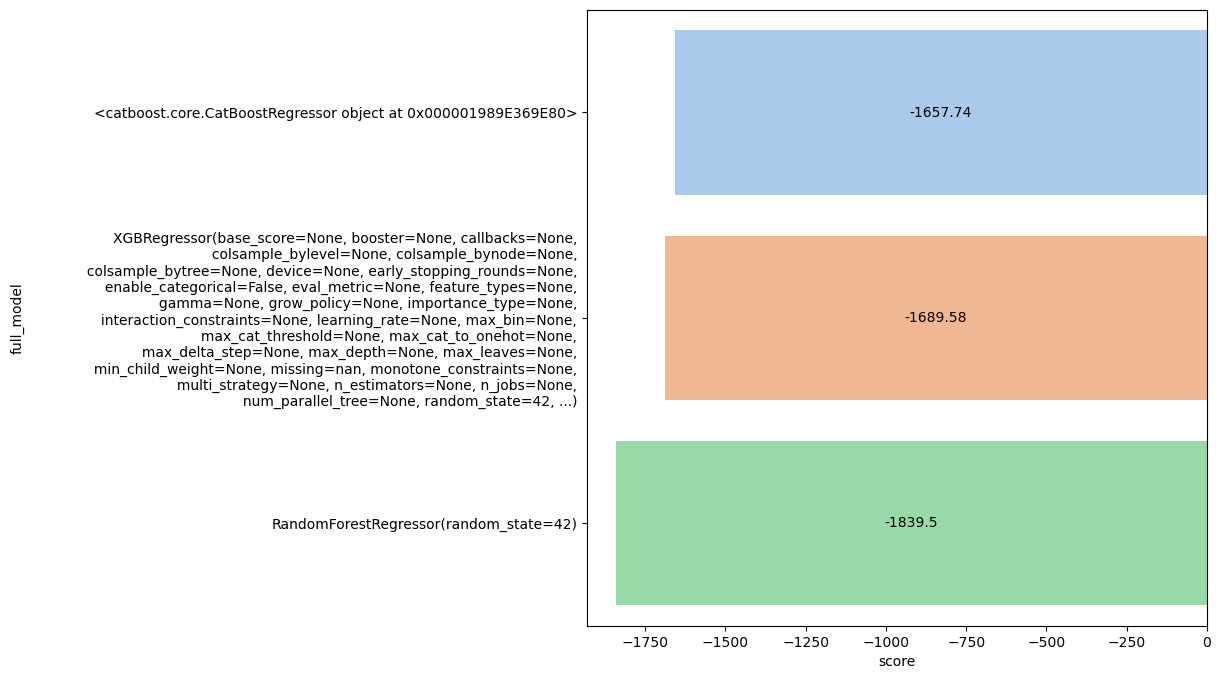

,full_model,score,rank,model
2,<catboost.core.CatBoostRegressor object at 0x0...,-1657.743279,1,<catboost.core.CatBoostRegressor object at 0x0...
0,"XGBRegressor(base_score=None, booster=None, ca...",-1689.578400,2,"XGBRegressor(base_score=None, booster=None, ca..."
1,RandomForestRegressor(random_state=42),-1839.503745,3,RandomForestRegressor(random_state=42)


In [19]:
model_list=[XGBRegressor(random_state=42), RandomForestRegressor(random_state=42), CatBoostRegressor(random_state=42)]

best_pipeline_reg(X, y_reg , model_list, scoring_type="neg_mean_squared_error", n=20)

#### I will continue with Catboost based on the above results

In [21]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, shuffle=True, test_size=0.3)

In [22]:
# Because my target variable is higly skewed i will apply log transformation for training 

y_train_log = np.log1p(y_train_reg) # log(1+x)


In [23]:
# Build a pipeline with feature selection, and CatBoostRegressor

pipeline_catboost = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_regression, k=20)),
    ('model', CatBoostRegressor(random_state=42, verbose=0))
])

# Define a parameter grid for CatBoost
param_grid_cat = {
    'model__depth': [6, 8, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__iterations': [100, 200]
}

# Setup GridSearchCV with the CatBoost pipeline
grid_search_cat = GridSearchCV(pipeline_catboost, param_grid_cat, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on training data
grid_search_cat.fit(X_train_reg, y_train_log)

# Best parameters and score
print("Best parameters:", grid_search_cat.best_params_)
print("Best cross-validation neg MSE:", grid_search_cat.best_score_)

# Predict in log-space
y_pred_log = grid_search_cat.predict(X_test_reg)

# Reverse the transformation to get predictions on the original scale
y_pred_original = np.expm1(y_pred_log)



rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_original))
mae = mean_absolute_error(y_test_reg, y_pred_original)
r2 = r2_score(y_test_reg, y_pred_original)

print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R²:", r2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'model__depth': 8, 'model__iterations': 200, 'model__learning_rate': 0.2}
Best cross-validation neg MSE: -0.2149828016975587
Test RMSE: 34.219574847977654
Test MAE: 23.088402244587705
Test R²: 0.44669631876239857


In [12]:
 # Apply target transformation (log transformation to stabilize variance)
y_log = np.log1p(y_reg)
    
# Split into training and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

# 3. Hyperparameter Tuning with Optuna
def objective(trial):
    # Suggest hyperparameters for SelectKBest and CatBoostRegressor
    k = trial.suggest_categorical('select_k_best__k', [10, 20, 30])
    depth = trial.suggest_int('model__depth', 6, 12)
    learning_rate = trial.suggest_loguniform('model__learning_rate', 0.01, 0.2)
    iterations = trial.suggest_int('model__iterations', 100, 400, step=50)
    
    # Build the pipeline
    pipeline = Pipeline([
        ('select_k_best', SelectKBest(score_func=f_regression, k=k)),
        ('model', CatBoostRegressor(random_state=42, verbose=0, depth=depth,
                                    learning_rate=learning_rate, iterations=iterations))
    ])
    
    # Evaluate using 5-fold CV with neg MSE (we maximize this score)
    scores = cross_val_score(pipeline, X_train, y_train_log, cv=5,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
print("  Value (mean neg MSE):", study.best_trial.value)
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# 4. Train final model on the entire training set using best parameters
best_params = study.best_trial.params
best_pipeline = Pipeline([
    ('select_k_best', SelectKBest(score_func=f_regression, k=best_params['select_k_best__k'])),
    ('model', CatBoostRegressor(
        random_state=42,
        verbose=0,
        depth=best_params['model__depth'],
        learning_rate=best_params['model__learning_rate'],
        iterations=best_params['model__iterations']
    ))
])

best_pipeline.fit(X_train, y_train_log)

# 5. Evaluate on the test set
y_pred_log = best_pipeline.predict(X_test)
# Reverse the target transformation to get predictions on original scale
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Evaluation on Test Set:")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")

[I 2025-02-19 17:53:44,728] A new study created in memory with name: no-name-286e7032-f961-4341-af9b-bd4f71e8817b
[I 2025-02-19 17:53:52,870] Trial 0 finished with value: -0.23631575451700582 and parameters: {'select_k_best__k': 20, 'model__depth': 8, 'model__learning_rate': 0.053308825432486814, 'model__iterations': 100}. Best is trial 0 with value: -0.23631575451700582.
[I 2025-02-19 17:53:59,189] Trial 1 finished with value: -0.27441620814052275 and parameters: {'select_k_best__k': 10, 'model__depth': 8, 'model__learning_rate': 0.051739522497034375, 'model__iterations': 100}. Best is trial 0 with value: -0.23631575451700582.
[I 2025-02-19 17:54:12,615] Trial 2 finished with value: -0.22676813126752432 and parameters: {'select_k_best__k': 20, 'model__depth': 8, 'model__learning_rate': 0.13045382117236248, 'model__iterations': 400}. Best is trial 2 with value: -0.22676813126752432.
[I 2025-02-19 17:54:18,308] Trial 3 finished with value: -0.24349570837999074 and parameters: {'select_k

Best trial:
  Value (mean neg MSE): -0.17264286932054376
  Params:
    select_k_best__k: 30
    model__depth: 9
    model__learning_rate: 0.0656277080698102
    model__iterations: 350

Final Evaluation on Test Set:
Test RMSE: 24.26
Test MAE: 16.31
Test R²: 0.72


In [13]:
# Top 30 features from best_pipeline using Optuna)
selected_mask = best_pipeline.named_steps['select_k_best'].get_support()
selected_features = X_train.columns[selected_mask]  # or use the expected features list if that's what you saved

print("Best 30 features selected:")
print(selected_features)

Best 30 features selected:
Index(['arrival_date_year', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'total_of_special_requests', 'reservation_year',
       'hotel_Resort Hotel', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_November', 'arrival_date_month_October', 'meal_HB',
       'country_PRT', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'distribution_channel_TA/TO', 'reserved_room_type_D',
       'reserved_room_type_F', 'reserved_room_type_G',
       'customer_type_Transient', 'customer_type_Transient-Party'],
      dtype='object')
